# Preliminary Info

**Model - SimpleAvgEmbed :** Simply takes the average of all tokens' embeddings inside a cell and passes to the FF Linear Layer for a Naive binary classification.

**Data Hierarchy Train/Val/Test = (80-10-10) : big > medium > small > tiny > micro > teeny**
- **big** (800 - 100 - 100)
- **medium** (400 - 50 - 50)
- **small** (200 - 25 - 25)
- **tiny** (100 - 12 - 12)
- **micro** (50 - 6 - 6)
- **teeny** (25 - 3 - 3)


# Colab Setup

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Navigate to the directory
%cd /content/drive/My Drive/Coding/idea/modules/runcolab

/content/drive/My Drive/Coding/idea/modules/runcolab


# Setup

## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, trainutil, inferutil
from classes import SpreadsheetDataLoader, GeluAvgEmbed

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(GeluAvgEmbed)

# Import the funcs needed from utils
from utils.selfutil import set_seed, get_vocab, get_fileList, create_embeddings
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.GeluAvgEmbed import GeluAvgEmbed

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter


# Setup device as a global constant
devstr = "cuda:0"  # Change to "cpu" or "mps" as needed
gpu = False if (devstr == 'cpu') else True

# Determine the device to use
if devstr.startswith('cuda') and torch.cuda.is_available():
    DEVICE = torch.device(devstr)
elif devstr.startswith('mps') and torch.backends.mps.is_available():
    DEVICE = torch.device(devstr)
else:
    DEVICE = 'cpu'  # Default to CPU if none of the above are available

# Determine the global count of threads to use in parallel operations
THREADS = 1

# Set the seed
set_seed(0)

# Print the device being used
print(f"Using device: {DEVICE}")

Using device: cuda:0


## Vocab/Embeddings

In [3]:
# Set the directory containing the spreadsheets for vocab training
vocab_dir = '../data/train_manual/'

# Get the vocabulary object and embeddings
spreadsheet_vocab = get_vocab(vocab_dir, 150000, space = True, case = 'both', threads = THREADS)
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)

Getting Vocab: 100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


40(P) = 40(G) + 0(E)
Unique Tokens: 5593
Vocab Size: 5597


Creating Word Embeddings: 100%|██████████| 5597/5597 [00:00<00:00, 54333.81it/s]

Word Embeddings Shape: torch.Size([5597, 50])


## File List and DataLoaders

In [4]:
# Define the directories
train_dir = '../data/train_manual/'
val_dir = '../data/val_manual/'
test_dir = '../data/test_manual/'

# Get the files for each directory
train_files = get_fileList(train_dir)
val_files = get_fileList(val_dir)
test_files = get_fileList(test_dir)

# Print the number of files in each list
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}\n")

# Decide max_rows, max_cols and num_tokens defaults 100, 100, 32
max_rows = 100
max_cols = 100
num_tokens = 32

# Create the data loaders
train_loader = SpreadsheetDataLoader(train_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
val_loader = SpreadsheetDataLoader(val_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
test_loader = SpreadsheetDataLoader(test_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)

Train files: 40
Validation files: 5
Test files: 5



Processing files: 100%|██████████| 40/40 [00:00<00:00, 49.41it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3091.78it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2771.44it/s]



5(P) = 5(G) + 0(E)


In [ ]:
# failed_count = len(train_loader.failed_files)
# print(f"\nFailed files in train_loader: {failed_count}")

# # Print the failed files for the train_loader
# if train_loader.failed_files:
#     print("Failed files in train_loader:")
#     for file in train_loader.failed_files:
#         print(file)
# else:
#     print("No failed files in train_loader.")


# Model Training

## Define the model

In [5]:
# Define the untrained model and move it to the device
untrained_model = GeluAvgEmbed(spreadsheet_wvs).to(DEVICE)
print(untrained_model)

GeluAvgEmbed(
  (_embed): Embedding(5597, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_non_linear): GELU(approximate='none')
  (_pred): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# # Get a single batch to test with
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=5, shuffle=False)
#
# # Get one batch from the DataLoader
# batch = next(iter(check_loader))
#
# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)
#
# # Define model
# untrained_model = SimpleAvgEmbed(spreadsheet_wvs).to(DEVICE)
#
# # Observe the model
# out = untrained_model.forward(exfile)
#
# print(f'Model Structure:\n{untrained_model}')
# print(out.shape)

# Training Loop

In [6]:
# Define the model training parameters
trained_model = train_model(
    model = untrained_model,
    train_data = train_loader,
    val_data = val_loader,
    DEVICE = DEVICE,
    batch_size = 40,
    lr = 1e-1,
    mu = 0.25,
    max_epochs = 20,
    patience = 2,
    save_int = 0,
    save_dir = '../models/',
    save_name = 'geluavgembed_manual'
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 1.7740119695663452, Perplexity: 1.0000177402770525
Val Loss: 0.6567593812942505, Perplexity: 1.0000065676153795


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.6696285605430603, Perplexity: 1.0000066963080256
Val Loss: 0.40871691703796387, Perplexity: 1.0000040871775229


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Train Loss: 0.41203582286834717, Perplexity: 1.0000041203667174
Val Loss: 0.33841022849082947, Perplexity: 1.000003384108011


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.34169164299964905, Perplexity: 1.0000034169222676
Val Loss: 0.3507622480392456, Perplexity: 1.0000035076286322


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Train Loss: 0.3463710844516754, Perplexity: 1.0000034637168431
Val Loss: 0.3138865530490875, Perplexity: 1.0000031388704567


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Train Loss: 0.3161345422267914, Perplexity: 1.0000031613504192
Val Loss: 0.3167535960674286, Perplexity: 1.0000031675409773


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Train Loss: 0.31367170810699463, Perplexity: 1.0000031367220006
Val Loss: 0.28714317083358765, Perplexity: 1.0000028714358309


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.28892219066619873, Perplexity: 1.0000028892260804
Val Loss: 0.2810988426208496, Perplexity: 1.000002810992377


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.2798687517642975, Perplexity: 1.000002798691434
Val Loss: 0.26753899455070496, Perplexity: 1.0000026753935243


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Train Loss: 0.269327849149704, Perplexity: 1.0000026932821184
Val Loss: 0.2604596018791199, Perplexity: 1.0000026045994108


Epoch 10


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Train Loss: 0.2620266377925873, Perplexity: 1.000002620269811
Val Loss: 0.2502714693546295, Perplexity: 1.0000025027178254


Epoch 11


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.25320637226104736, Perplexity: 1.0000025320669284
Val Loss: 0.24320542812347412, Perplexity: 1.0000024320572387


Epoch 12


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Train Loss: 0.24554365873336792, Perplexity: 1.0000024554396019
Val Loss: 0.2342063933610916, Perplexity: 1.0000023420666762


Epoch 13


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Train Loss: 0.23957300186157227, Perplexity: 1.0000023957328883
Val Loss: 0.2275363951921463, Perplexity: 1.0000022753665405


Epoch 14


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Train Loss: 0.23128901422023773, Perplexity: 1.0000023128928168
Val Loss: 0.21881477534770966, Perplexity: 1.0000021881501475


Epoch 15


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Train Loss: 0.22449499368667603, Perplexity: 1.0000022449524568
Val Loss: 0.2124532163143158, Perplexity: 1.00000212453442


Epoch 16


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Train Loss: 0.2182151824235916, Perplexity: 1.000002182154205
Val Loss: 0.2038736343383789, Perplexity: 1.0000020387384216


Epoch 17


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Train Loss: 0.21181620657444, Perplexity: 1.000002118164309
Val Loss: 0.1986667960882187, Perplexity: 1.0000019866699343


Epoch 18


Validation Processing: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Train Loss: 0.2056639939546585, Perplexity: 1.0000020566420544
Val Loss: 0.190179705619812, Perplexity: 1.0000019017988646


Epoch 19


Validation Processing: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

Train Loss: 0.19892825186252594, Perplexity: 1.0000019892844974
Val Loss: 0.1861705482006073, Perplexity: 1.000001861707215



TRAINING DONE at epoch 19, best epoch 19
Train Loss = 0.19892825186252594, Perplexity = 1.0000019892844974
Val Loss = 0.1861705482006073, Perplexity = 1.000001861707215


# Evaluation

## Single File for Train/Val/Test


Filename: ../data/train_manual/Harassment-Bullying-on-basis-of-disability_discplined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(6,1): 0.915267
(5,18): 0.923679
(5,3): 0.925319
(5,22): 0.927145
(3,1): 0.929307
(4,5): 0.929447
(4,11): 0.930006
(5,4): 0.937465
(3,2): 0.950887
(3,3): 0.952118
(3,23): 0.963247
(3,21): 0.965941
(4,15): 0.973447
(4,9): 0.977468
(3,24): 0.979270
(4,3): 0.980957
(4,7): 0.984529
(4,13): 0.987266
(3,17): 0.987391
(3,19): 0.991803
(1,1): 0.993282

NB to B ratio: Predicted = 9905:95 | Actual = 9907:93
Accuracy: 99.96% | Precision: 96.84% | Recall: 98.92% | F1-Score: 0.98



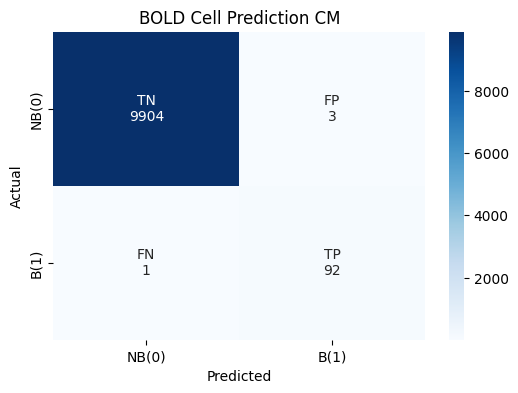


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
infer_one(trained_model, train_loader, loc=20, disp_max = True, threshold = 0.92, condition = '>', device = DEVICE)


Filename: ../data/val_manual/portfolio-by-debt-size.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(6,0): 0.923465
(21,0): 0.924571
(17,0): 0.926209
(7,1): 0.927445
(6,1): 0.927487
(13,0): 0.927632
(8,1): 0.927999
(9,0): 0.929182
(9,1): 0.929406
(4,14): 0.932288
(4,18): 0.943872
(4,8): 0.961363
(4,10): 0.964476
(4,16): 0.965873
(5,0): 0.965935
(4,12): 0.966357
(4,4): 0.966481
(4,2): 0.966614
(4,6): 0.966616
(5,3): 0.986067
(0,0): 0.993562
(5,2): 0.994560
(5,4): 0.995059

NB to B ratio: Predicted = 9908:92 | Actual = 9908:92
Accuracy: 100.00% | Precision: 100.00% | Recall: 100.00% | F1-Score: 1.00



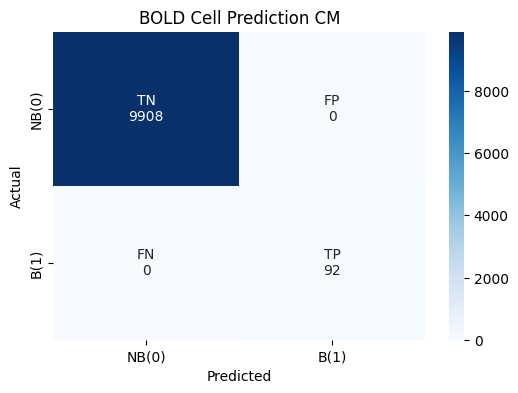


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
infer_one(trained_model, val_loader, loc=0, disp_max = True, threshold = 0.92, condition = '>', device = DEVICE)


Filename: ../data/test_manual/Harassment-Bullying-on-basis-of-sex_disciplined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(6,1): 0.915267
(5,18): 0.923679
(5,3): 0.925319
(5,22): 0.927145
(3,1): 0.929307
(4,5): 0.929447
(4,11): 0.930006
(5,4): 0.937465
(3,2): 0.950887
(3,3): 0.952118
(3,23): 0.963247
(3,21): 0.965941
(4,15): 0.973447
(4,9): 0.977468
(3,24): 0.979270
(4,3): 0.980957
(4,7): 0.984529
(4,13): 0.987266
(3,17): 0.987391
(3,19): 0.991803
(1,1): 0.993282

NB to B ratio: Predicted = 9928:72 | Actual = 9930:70
Accuracy: 99.96% | Precision: 95.83% | Recall: 98.57% | F1-Score: 0.97



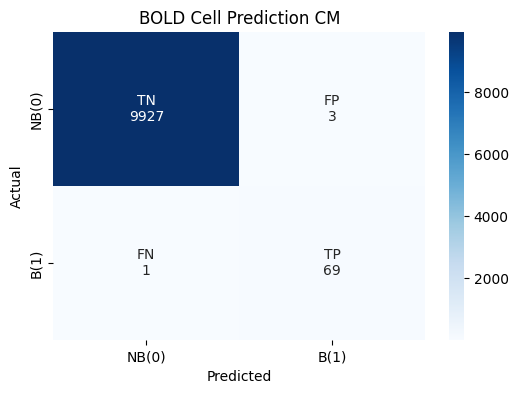


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
infer_one(trained_model, test_loader, loc=2, disp_max = True, threshold = 0.92, condition = '>', device = DEVICE)

## Multi file for train/val/test

Processing files: 100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


--- Average Metrics Across All Files ---

Total Files Processed: 40

NB to B ratio: Predicted = 396678:3322 | Actual = 396714:3286
Accuracy: 99.99% | Precision: 98.56% | Recall: 99.66% | F1-Score: 0.99



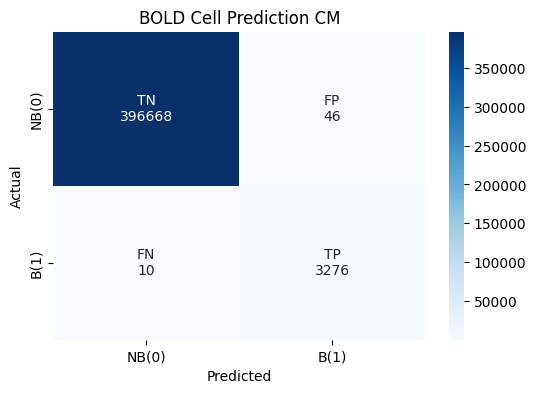

In [15]:
infer_full(trained_model, train_loader, is_subset=False, threshold=0.92, device=DEVICE)

Processing files: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


--- Average Metrics Across All Files ---

Total Files Processed: 5

NB to B ratio: Predicted = 49597:403 | Actual = 49602:398
Accuracy: 99.99% | Precision: 98.29% | Recall: 99.71% | F1-Score: 0.99



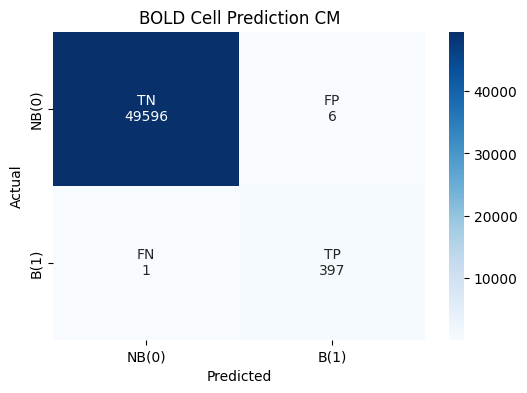

In [16]:
infer_full(trained_model, val_loader, is_subset=False, threshold=0.92, device=DEVICE)

Processing files: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


--- Average Metrics Across All Files ---

Total Files Processed: 5

NB to B ratio: Predicted = 49619:381 | Actual = 49606:394
Accuracy: 99.95% | Precision: 98.27% | Recall: 96.90% | F1-Score: 0.97



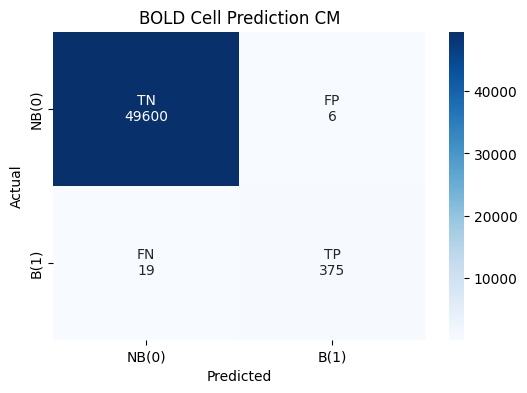

In [17]:
infer_full(trained_model, test_loader, is_subset=False, threshold=0.92, device=DEVICE)